In [1]:
import os
import sys
from pathlib import Path
# Make sure all code is in the PATH.
sys.path.append("../src/")

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

In [3]:
# Plot styling.
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans-serif")
sns.set_palette(["#9e0059", "#6da7de", "#ee266d", "#dee000", "#eb861e"])
sns.set_context("paper")

# ensure directory
Path("results/img/").mkdir(parents=True, exist_ok=True)

## Finished setup, start plotting

In [4]:
# filename = "results/BILELIB19_all_sqrt_False_2000000pairs_6min_signals_True_requirestruc_4i0-200deltamz_0mods.parquet"
filename = "results/20220418_ALL_GNPS_NO_PROPOGATED_all_sqrt_False_10000000pairs_6min_signals_True_requirestruc_4i0-200deltamz_0mods.parquet"
# filename = "results/20220418_ALL_GNPS_NO_PROPOGATED_all_sqrt_False_5000000pairs_6min_signals_True_requirestruc_4i0-200deltamz_0mods.parquet"
# filename = "results/20220418_ALL_GNPS_NO_PROPOGATED_hexose_sqrt_False_500000pairs_6min_signals_True_requirestruc_162i05282400000002specific_delta_0mods.parquet"
# filename = "results/BILELIB19_aminos_sqrt_False_200000pairs_6min_signals_True_requirestruc_4i0-200deltamz_5mods.parquet"
# filename = "results/BILELIB19_oxy_sqrt_False_500000pairs_6min_signals_True_requirestruc_15i9949specific_delta_0mods.parquet"

# use filename to identify exported files
analysis_id = Path(filename).stem

similarities = pd.read_parquet(filename)
similarities.head(5)

,id1,id2,delta_mz,tanimoto,cos_score,cos_matched_intensity,cos_max_contribution,cos_n_greq_2p,cos_matches,mod_score,mod_matched_intensity,mod_max_contribution,mod_n_greq_2p,mod_matches,nl_score,nl_matched_intensity,nl_max_contribution,nl_n_greq_2p,nl_matches
0,CCMSLIB00005753548,CCMSLIB00006691107,117.068,0.1072,0.009034,0.227256,0.005347,0,11,0.010308,0.227730,0.005347,0,11,0.002129,0.124750,0.002129,0,1
1,CCMSLIB00006708182,CCMSLIB00006691703,123.928,0.2577,0.049627,0.651757,0.006468,0,84,0.133049,0.863047,0.034562,2,109,0.090106,0.334506,0.034562,2,42
2,CCMSLIB00006700259,CCMSLIB00006691156,113.993,0.2066,0.000015,0.004877,0.000012,0,3,0.002078,0.426866,0.002033,0,5,0.002066,0.783621,0.002033,0,3
3,CCMSLIB00006699505,CCMSLIB00005735250,132.926,0.1512,0.004973,0.734883,0.004449,0,11,0.004977,0.752919,0.004449,0,12,0.000003,0.001719,0.000003,0,1
4,CCMSLIB00000568988,CCMSLIB00005777685,173.969,0.3349,0.010959,0.124588,0.006047,0,10,0.011768,0.137595,0.006047,0,13,0.000810,0.014554,0.000735,0,3


In [5]:
# remove rows where all scores are 0
similarities = similarities[(similarities["cos_score"]>0) & (similarities["mod_score"]>0) & (similarities["nl_score"]>0)]
len(similarities)

3899314

In [6]:
total = len(similarities)
stats = {
    'total': total,
    'cos higher': len(similarities[similarities["cos_score"]>similarities["nl_score"]])/ total,
    'nl higher': len(similarities[similarities["cos_score"]<similarities["nl_score"]])/ total
}
print(stats)

{'total': 3899314, 'cos higher': 0.530212750242735, 'nl higher': 0.469751602461356}


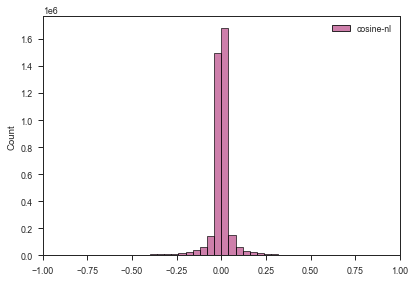

In [7]:
df = pd.DataFrame()
df['cosine-nl'] = similarities['cos_score'] - similarities['nl_score']
ax = sns.histplot(data=df, binwidth=0.04)
ax.set_xlim((-1,1))

plt.savefig("results/img/diff_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [8]:
def group_tanimoto(tanimoto):
    if tanimoto >= 0.8: return "≥0.8"
    if tanimoto >= 0.6: return "≥0.6"
    if tanimoto >= 0.4: return "≥0.4"
    if tanimoto >= 0.0: return "≥0"
    else: return 'unclassified'

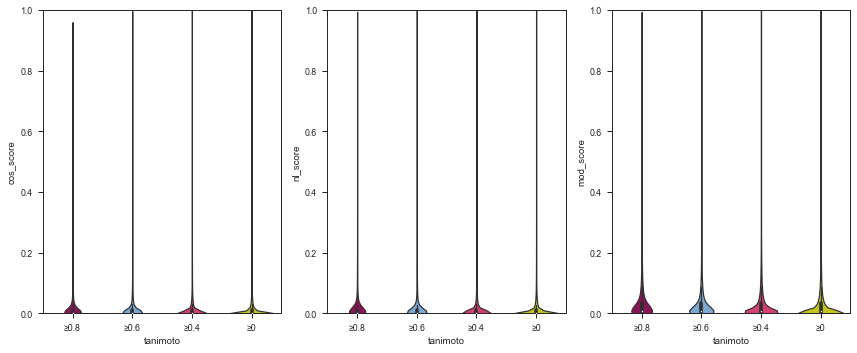

In [9]:
# tanimoto score
hueorder = ["≥0.8","≥0.6","≥0.4","≥0"]
similarities["tanimoto_cat"] = similarities["tanimoto"].apply(group_tanimoto)

score = ["cos_score","nl_score","mod_score"]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, ax in enumerate(axes.flatten()):
    sns.violinplot(y=score[i],
                   x="tanimoto_cat",
                   data=similarities,
                   cut=0,
                   ax=ax,
                   order=hueorder
                   )
    ax.set_xlabel("tanimoto")
    ax.set_ylim((0,1))

    # sns.stripplot(y=score[i],
    #               x="tanimoto_cat",
    #               data=similarities,
    #               ax=ax,
    #               order=hueorder,
    #               color="black", edgecolor="gray", size=2)


plt.tight_layout()

plt.savefig("results/img/tanimoto_violin_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
labels = np.asarray([
    ["nl_score", "cos_score"],
    ["cos_score", "mod_score"],
    ["nl_score", "mod_score"]
])

mosaic = """
11111.
222223
222223
222223
222223
222223
"""

bins = 100
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

with sns.plotting_context("paper", font_scale=1.6):
    fig = plt.figure(constrained_layout=True, figsize=(7.2 * 2, 7.2 / 1.618))
    left, middle, right = fig.subfigures(nrows=1, ncols=3)
    axes_left = left.subplot_mosaic(mosaic)
    axes_middle = middle.subplot_mosaic(mosaic)
    axes_right = right.subplot_mosaic(mosaic)
    cbar_ax = fig.add_axes([1.03, 0.25, 0.02, 0.5])

    for i, (axes, (xlabel, ylabel)) in enumerate(
            zip([axes_left, axes_middle, axes_right], labels)
    ):
        # Plot heatmaps.
        hist, _, _ = np.histogram2d(
            similarities[xlabel],
            similarities[ylabel],
            bins=bins,
            range=[[0, 1], [0, 1]],
        )
        hist /= len(similarities)
        heatmap = sns.heatmap(
            np.rot90(hist),
            vmin=0.0,
            vmax=0.01,
            cmap="viridis",
            cbar=i == 2,
            cbar_kws={"format": mticker.StrMethodFormatter("{x:.3%}")},
            cbar_ax=cbar_ax if i == 2 else None,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes["2"],
            norm=LogNorm(),
        )
        axes["2"].yaxis.set_major_locator(tick_locators)
        axes["2"].set_yticklabels(tick_labels[::-1])
        axes["2"].xaxis.set_major_locator(tick_locators)
        axes["2"].set_xticklabels(tick_labels)
        for _, spine in heatmap.spines.items():
            spine.set_visible(True)
        axes["2"].set_xlabel(xlabel.replace("_", " ").capitalize())
        axes["2"].set_ylabel(ylabel.replace("_", " ").capitalize())

        axes["2"].plot(
            [0, bins], [bins, 0], color="black", linestyle="dashed"
        )

        sns.despine(ax=axes["2"])

        # Plot density plots.
        sns.kdeplot(
            data=similarities,
            x=xlabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["1"],
        )
        axes["1"].set_xlim(0, 1)
        axes["1"].xaxis.set_ticklabels([])
        axes["1"].yaxis.set_major_locator(tick_locators)
        axes["1"].set_yticks([])
        sns.despine(ax=axes["1"], left=True)
        sns.kdeplot(
            data=similarities,
            y=ylabel,
            clip=(0, 1),
            legend=True,
            color="black",
            fill=True,
            ax=axes["3"],
        )
        axes["3"].set_ylim(0, 1)
        axes["3"].yaxis.set_ticklabels([])
        axes["3"].xaxis.set_major_locator(tick_locators)
        axes["3"].set_xticks([])
        sns.despine(ax=axes["3"], bottom=True)
        for ax in [axes[c] for c in "13"]:
            ax.set_xlabel("")
            ax.set_ylabel("")

    cbar_ax.set_ylabel("Proportion of pairs")
    cbar_ax.yaxis.set_label_position("left")
    cbar_ax.spines["outline"].set(visible=True, lw=.8, edgecolor="black")

    plt.savefig("results/img/combined_plots_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
    plt.savefig("massivekb_peptide_mods.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

In [ ]:
plots = [
        ["nl_score", "cos_score"],
        ["cos_score", "mod_score"],
        ["nl_score", "mod_score"],
        ["nl_max_contribution", "nl_score"],
        ["cos_max_contribution", "cos_score"],
        ["mod_max_contribution", "mod_score"],
        ["nl_matched_intensity", "nl_score"],
        ["cos_matched_intensity", "cos_score"],
        ["mod_matched_intensity", "mod_score"],
        ["nl_matched_intensity", "cos_matched_intensity"],
        ["nl_max_contribution", "cos_max_contribution"],
        ["nl_max_contribution", "mod_max_contribution"],
        ["cos_score", "tanimoto"],
        ["nl_score", "tanimoto"],
        ["mod_score", "tanimoto"],
    ]

fig, axes = plt.subplots(5, 3, figsize=(7, 15 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

for i, ax in enumerate(axes.flatten()):
    if i >= len(plots):
        break

    (xlabel, ylabel) = plots[i]
    hist, _, _ = np.histogram2d(
        similarities[xlabel],
        similarities[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax,
        norm=LogNorm(),
    )
    ax.yaxis.set_major_locator(tick_locators)
    ax.set_yticklabels(tick_labels[::-1])
    ax.xaxis.set_major_locator(tick_locators)
    ax.set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    ax.set_ylabel(ylabel.replace("_", " ").capitalize())


plt.tight_layout()

plt.savefig("results/img/score_contributions_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
plots = [
    ["nl_score", "cos_score"],
    ["cos_score", "mod_score"],
    ["nl_score", "mod_score"],
    ["nl_max_contribution", "nl_score"],
    ["cos_max_contribution", "cos_score"],
    ["mod_max_contribution", "mod_score"],
    ["nl_matched_intensity", "nl_score"],
    ["cos_matched_intensity", "cos_score"],
    ["mod_matched_intensity", "mod_score"],
    ["nl_matched_intensity", "cos_matched_intensity"],
    ["nl_max_contribution", "cos_max_contribution"],
    ["nl_max_contribution", "mod_max_contribution"],
    ["cos_score", "tanimoto"],
    ["nl_score", "tanimoto"],
    ["mod_score", "tanimoto"],
]

filtered_df = similarities[similarities["tanimoto"]>0.6]

fig, axes = plt.subplots(5, 3, figsize=(7, 15 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

for i, ax in enumerate(axes.flatten()):
    if i >= len(plots):
        break

    (xlabel, ylabel) = plots[i]
    hist, _, _ = np.histogram2d(
        filtered_df[xlabel],
        filtered_df[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax,
        norm=LogNorm(),
    )
    ax.yaxis.set_major_locator(tick_locators)
    ax.set_yticklabels(tick_labels[::-1])
    ax.xaxis.set_major_locator(tick_locators)
    ax.set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    ax.set_ylabel(ylabel.replace("_", " ").capitalize())


plt.tight_layout()

plt.savefig("results/img/tanimoto_filter_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

xlabels = ["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]
max_x = similarities[["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]].max().max()
max_y = max(similarities[xlabel].value_counts()[0] for xlabel in xlabels) * 1.02

for i, ax in enumerate(axes.flatten()):
    xlabel = xlabels[i]

    hist = sns.histplot(data=similarities, x=xlabel, binwidth=1, ax= ax)
    # for _, spine in hist.spines.items():
    #     spine.set_visible(True)
    # ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    # ax.set_ylabel(ylabel.replace("_", " ").capitalize())

    ax.set_xlim((0,max_x))
    ax.set_ylim((0,max_y))

plt.tight_layout()

plt.savefig("results/img/greater_2p_signals_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
g = sns.pairplot(similarities, kind="hist",
             vars=["cos_score", "nl_score", "mod_score", "cos_max_contribution", "nl_max_contribution"])
for axes in g.axes:
    for a in axes:
        a.set_xlim((0,1))
        a.set_ylim((0,1))

plt.savefig("results/img/pair_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()